#  SARSA and Q-Learning

## Frozen Lake

The Frozen Lake environment is an uncertain grid world in which you start from an initial state (the top leftmost square) and move to an end state (the bottom rightmost square). The environment is uncertain because you are walking on a frozen lake and the thickness of the ice varies. You can therefore fall into the water in some squares. Also, the ice is more slippery in some places, so taking a step may take you further than you expected... and if the wind gets in the way...

Instead of trying to estimate the transition pattern, we will use SARSA and Q-learning to solve this problem.

Use the Frozen Lake environment to implement SARSA and Q-learning. First use the environment with a 4x4 grid to test your algorithms, then you should be able to use them for the 16x16 grid.



In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym


## $\epsilon$-greedy

Implémentez une fonction qui retourne une action avec la stratégie $\epsilon$-greedy:
* exploite avec un probabilité $1-\epsilon$: ici on choisit l'action avec la meilleure valeur de $q[s]$
* explore avec une probabilité $\epsilon$: on choisit une action de manière uniforme sur toute les actions.

Vous pouvez choisir différente signature pour la fonction:
soit en lui passant:
 * le paramètre $\epsilon$
 * la table `Q`
 * l'état `s` dans lequel l'action sera exécutée
 * donc l'appel aura la forme `action = epsGreedy(eps, Q, s)`

 Autre solution, vous pouvez donner seulement la valeur de $\epsilon$ et vecteur Q(s) (qui a pour dimension le nombre d'actions). L'appel aura donc la forme `action = epsGreedy(eps, q)`

*Attention* On peut imaginer le cas particulier où on trouve plusieurs occurrence de la valeur max dans le vecteur `Q(s)`. Dans ce cas, il ne faudrait pas *toujours* choisir la même action, mais plutôt choisir une des actions ex-aequo au hasard. 
Ce cas n'est peut-être pas si exotique que cela, en particulier en début d'apprentissage, quand toutes les valeurs sont nulles. Pour explorer, il est alors souhaitable de répéter le même choix!


Pour ceux peu familier avec python, regardez le petit exemple de code ci-dessous pour illustrer quelques fonctions de la bibliothèque `numpy`
- La fonction `np.random.rand()` tire une valeur de manière uniforme entre 0 et 1. 
- La fonction np.random.choice permet de choisir de manière uniforme une valeur parmi un ensemble.
- La fonction `np.argwhere(l)` permet de donner les indices où l'entrée du vecteur l est non nul. On peut donc coupler un appel de `np.argwhere` avec un test.



In [34]:
def epsGreedy(epsilon, q, s):
    proba = random.random()
    
    if (q[s] == 0).all():
        best_action = random.randint(0, 3)
    else:
        best_action = np.argmax(q[s,:])


    if proba < epsilon:
        action = random.randint(0, 3)
    else:
        action = best_action
        
    return action

## Tester une politique

Lors de l'apprentissage, il est nécessaire d'explorer, ainsi lorsqu'on analyse les performances durant l'apprentissage, il faut avoir à l'esprit qu'une partie des choix est faite au hasard. Après avoir appris, on peut faire un test en étant glouton: à chaque état, on choisit toujours l'action qui donne la plus haute valeur de `Q`.
Implémentez une méthode qui prend en paramètre un nombre d'épisodes fixé, une table `Q`, et qui exécute la politique gloutone. La méthode retourne la valeur moyenne de la somme des récompenses sur l'épisode.

In [35]:
def test_strategy(q, n_episodes, env):
    reward_array = np.zeros(n_episodes)
    for i in range(n_episodes):
        nb_iterations = 0
        state = env.reset()
        state = state[0]
        action = np.argmax(q[state])
        done = False
        while (not done) & (nb_iterations<1000): # reduce computation time as 8x8 map can be long
            nb_iterations+=1
            next_state, reward, done, info, prob = env.step(action)
            next_action = np.argmax(q[next_state])
            if done:
                reward_array[i] = reward
                break
            state, action = next_state, next_action
    env.close()
    return sum(reward_array)/len(reward_array)

### SARSA

Implémentez un fonction SARSA qui prend en paramètre
 * un nombre d'épisodes utilisés pour l'apprentissage
 * $\gamma$ le taux d'escompte
 * $\alpha$ le taux d'apprentissage (que l'on retrouve lors de la mise à jour des valeurs de Q)
 * $\epsilon$ le paramètre pour la méthode $\epsilon$-greedy.

Votre fonction doit au moins retourner la table $Q: S \times A$. Vous trouverez ci-dessous une fonction $plotQ$ qui génère une représentation de la table $Q$: pour chaque case sera dessiné la meilleure action selon $Q$ et la couleur représentera la valeur de cette action.
 
Pour visualiser les progrès faits pendant l'apprentissage, votre fonction SARSA peut également retourner une séquence de valeurs. Par exemple,
 * la séquence de récompenses (totale ou moyenne) obtenue sur chaque épisode de l'apprentissage
 * la valeur de la meilleure action pour l'état de départ à chaque fin d'épisode.
 * au lieu d'utiliser les valeurs obtenues lors de l'apprentissage, vous pouvez aussi effectuer périodiquement une évaluation de la politique courante (sans exploration). Pour ce faire, vous pouvez calculer la performance sur un petit nombre d'épisodes et retourner la moyenne. Cette méthode a l'avantage d'évaluer la politique sans exploration (donc une meilleure évaluation de la politique), mais peut coûter cher en temps de calcul suivant la fréquence d'exécution et le nombre d'épisodes utilisés pour l'évaluation.

En générant le graphique, vous devriez visualiser si l'algorithme est arrivé à améliorer les performances. Vous pouvez soit tracer directement la valeur de chaque épisode. Pour avoir une courbe un peu plus lisse, vous pouvez aussi calculer une moyenne sur une fenêtre de $k$ épisodes (la fonction $runningAvg$ effectue ce travail).

Notez qu'on considère Frozen lake comme résolu quand
 * il atteint le but dans 78% des épisodes pour la grille 4x4.
 * a priori, on peut atteindre 100% pour la grille 8x8

Quelques idées pour aider au debeug:
 * vous pouvez aussi regarder si la plupart des paires état-actions ont été exécutée. 
 * Vous pouvez choisir comme paramètres (le code que j'ai écrit a fonctionné avec ces paramètres, évidemment, vous pouvez essayer avec d'autres par la suite).
   * $\epsilon=0.2$
   * $\alpha=0.02$
   * Frozen lake est une tâche épisodique, donc ici, on peut s'intéresser simplement à la somme des récompenses accumulées lors d'un épisode. Donc on peut choisir $\gamma=1$ (pas d'escompte).

In [36]:
n_episodes = 5000
alpha = 0.02
gamma = 1
epsilon = 0.2

def frozenlake_sarsa(alpha,gamma, epsilon,  n_episodes, map_size = "4x4", slippery = True):
    env = gym.make("FrozenLake-v1", map_name=map_size, is_slippery=slippery) # default 4 x 4 map with sliding
    numStates = env.observation_space.n
  
    numActions = env.action_space.n

    #define q
    q = np.zeros((numStates,numActions))
    action_count = np.zeros((numStates,numActions))

    #initial conditions
    state = env.reset()
    nextState = state[0]
    nbIt=0

    action = epsGreedy(epsilon,q,nextState)
    prevState = nextState
    
    test_rewards = {}
    for i in range(n_episodes):
        if i%1000==0:
            print(i) # print the episode once every 1000 iterations 
        if i%100==0:
            test_rewards[i] = test_strategy(q, 50, env) #evaluate current policy on 50 episodes
        done=False
        while (not done) :
            nextState, reward, done, info, prob = env.step(action)
            action_count[prevState, action] +=1
            nbIt+=1
            if done: 
                q[prevState, action] += alpha*(reward - q[prevState, action])
                state = env.reset()
                nbIt=0
                nextState = state[0]
                action = epsGreedy(epsilon,q,nextState)  
                prevState = nextState      
            else:
                prevAction = action
                action = epsGreedy(epsilon,q,nextState)
                q[prevState, prevAction] += alpha*(reward + gamma*q[nextState, action] - q[prevState, prevAction])
                prevState = nextState
    env.close()
    return q , test_rewards


In [ ]:
q_sarsa_4 , test_rewards_sarsa_4  = frozenlake_sarsa(alpha,gamma, epsilon,n_episodes=20000, map_size ="4x4", slippery = True)
q_sarsa_8 , test_rewards_sarsa_8  = frozenlake_sarsa(alpha,gamma, epsilon,n_episodes=20000, map_size ="8x8", slippery = True)


In [38]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res


# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

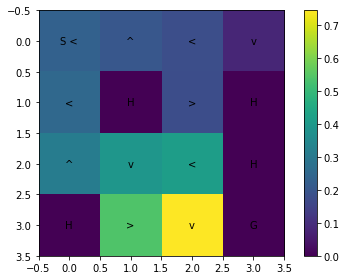

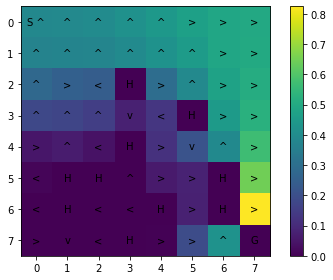

In [39]:
plotQ(q_sarsa_4, 4)
plotQ(q_sarsa_8,8)

## Q-learning
Implémentez l'algorithme Q-learning (en partant de SARSA, il ne devrait y avoir que quelques lignes de codes à modidier!)



In [40]:
# à implémenter
n_episodes = 5000
alpha = 0.02
gamma = 1
epsilon = 0.2

def frozenlake_q_learning(alpha,gamma, epsilon,  n_episodes, map_size = "4x4" , slippery = False):
    env = gym.make("FrozenLake-v1", map_name=map_size, is_slippery=slippery) # default 4 x 4 map without sliding
    numStates = env.observation_space.n
    numActions = env.action_space.n

    #define q
    q = np.zeros((numStates,numActions))
    action_count = np.zeros((numStates,numActions))

    #initial conditions
    state = env.reset()
    nextState = state[0]
    nbIt=0
   
    action = epsGreedy(epsilon,q,nextState)
    prevState = nextState
    test_rewards = {}
    for i in range(n_episodes):
        if i%1000==0:
            print(i)
        if i%100==0:
            test_rewards[i] = test_strategy(q, 50,env)
        done=False
        while (not done) :

            nextState, reward, done, info, prob = env.step(action)

            action_count[prevState, action] +=1

            nbIt+=1
            
            
            if done:
         
                q[prevState, action] += alpha*(reward - q[prevState, action])
                state = env.reset()
                nbIt=0
                nextState = state[0]
                action = epsGreedy(epsilon,q,nextState)  
                prevState = nextState
                

            else:
                prevAction = action
                q[prevState, prevAction] += alpha*(reward + gamma*q[nextState, np.argmax(q[nextState])] - q[prevState, prevAction])
                action = epsGreedy(epsilon,q,nextState)
                prevState = nextState
                
                
    env.close()
    return q, test_rewards


In [ ]:
q_q_learning_4 , test_rewards_q_learning_4 = frozenlake_q_learning(alpha,gamma, epsilon,  n_episodes=20000, map_size = "4x4", slippery = True)

q_q_learning_8 , test_rewards_q_learning_8 = frozenlake_q_learning(alpha,gamma, epsilon,  n_episodes=20000, map_size = "8x8", slippery = True)


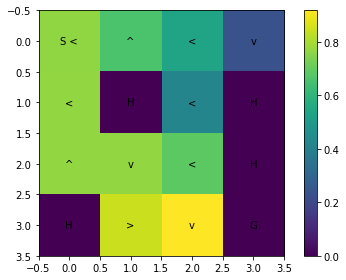

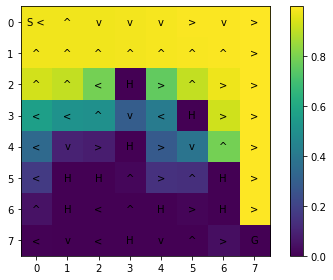

In [42]:
plotQ(q_q_learning_4, 4)
plotQ(q_q_learning_8,8)

## Comparaison

Comparer les politiques trouvées à l'aide de SARSA, Q-learning, et vous devriez aussi pouvoir utiliser le code de l'algorithme on policy Monte Carlo du TD précédent.

Avant convergence à l'optimal, on observe souvent que SARSA a choisi une politique moins risquée avant de tomber sur l'optimal pour le FrozenLake8x8.

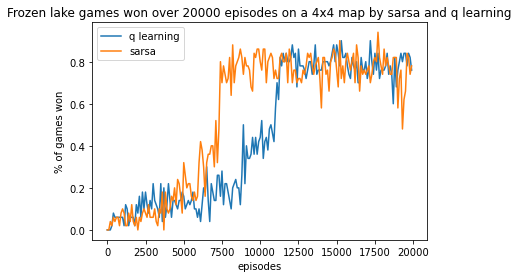

In [43]:
plt.plot(test_rewards_q_learning_4.keys(),test_rewards_q_learning_4.values() , label = 'q learning')
plt.plot(test_rewards_sarsa_4.keys(),test_rewards_sarsa_4.values(), label = 'sarsa')
plt.legend()
plt.xlabel('episodes')
plt.ylabel('% of games won')
plt.title('Frozen lake games won over 20000 episodes on a 4x4 map by sarsa and q learning')
plt.show()

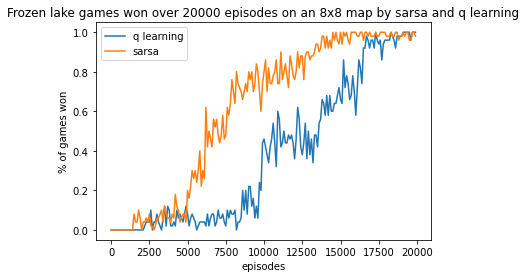

In [44]:
plt.plot(test_rewards_q_learning_8.keys(),test_rewards_q_learning_8.values() , label = 'q learning')
plt.plot(test_rewards_sarsa_8.keys(),test_rewards_sarsa_8.values(), label = 'sarsa')
plt.legend()
plt.xlabel('episodes')
plt.ylabel('% of games won')
plt.title('Frozen lake games won over 20000 episodes on an 8x8 map by sarsa and q learning')
plt.show()

## Cart-pole en tabulaire

On vous propose pour finir d'utiliser votre code et de tester l'apprentissage sur le problème du cart-pole. A priori, c'est un problème où les états sont des variables continues. On vous propose ici de discrétiser les variables et d'essayer d'utiliser une des méthodes pour voir vos résultats. 

La récompense que vous obtenez est le nombre de pas de temps où le baton est resté en équilibre. Si vous utilisez colab pour coder, vous ne pourrez malheureusement pas visualiser un épisode avec la méthode render :-(

Cet environnement Cart-Pole consiste à déplacer un chariot pour faire tenir en équilibre une poutre. Plus précisément:
* Il y a deux actions : gauche et droite (représentées par 0 et 1).
* L'observation reçue (c'est à dire l'état) est un tableau numpy comprenant 4 variables: la position du chariot, la vélocité, l'angle à la verticale et la position du haut de la poutre.
* L'épisode se termine lorsque l'angle de la poutre à la verticale dépasse 12 degrés.
* Les récompenses reçues sont égales à 1 sauf si l'angle dépasse 12 degrés.

On vous donne ci-dessous les fonctions pour réaliser la discrétisation et pour encoder l'état en un entier.


In [45]:
env = gym.make("CartPole-v1")
print("environnement avec ", env.action_space.n, " actions")
print("l'espace des états est lui codé avec une class", env.observation_space,
      " qui représente un espace continu")
print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
env.reset()
nbIt=0
done=False
while not done:
  observation, reward, done, info, smth = env.step(np.random.randint(2))
  nbIt+=1
print("Episode terminé après {} itérations".format(nbIt))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 14 itérations


In [46]:
def discretise(x,mini,maxi): 
  # discretise x
  # renvoie un entier entre 0 et nval-1
  if x<mini: x=mini
  if x>maxi: x=maxi
  return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
  pos = discretise(observation[0],mini=-1,maxi=1)
  vel = discretise(observation[1],mini=-1,maxi=1)
  angle = discretise(observation[2],mini=-1,maxi=1)
  pos2 = discretise(observation[3],mini=-1,maxi=1)
  return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval
  

In [47]:
nval =5 # nombre de valeurs discrètes qu’une variable peut prendre
N= nval ** 4 # Puisqu’il y a 4 variables, la taille de l’espace est nval^4
print("Le nombre d'états sera ici de ", N)

Le nombre d'états sera ici de  625


Modifiez votre implémentation de Q-learning et/ou de SARSA pour tester si vous pouvez apprendre à maintenier le baton en équilibre. Une modification sera d'utilisé les fonctions ci-dessus pour encoder/decoder un état. Une autre sera surement d'ajouter le nombre d'états en paramètre car ce nombre est maintenant indépendant de l'environnement! 
Avec comme paramètre $\epsilon=0.1$, $\alpha=0.2$ et $\gamma=0.9$, j'arrive a atteindre un score autour de 90 pas de temps.

In [48]:
def epsGreedy(epsilon, q, s):
    proba = random.random()
    
    if (q[s] == 0).all():
        best_action = random.randint(0, 1)
    else:
        best_action = np.argmax(q[s,:])


    if proba < epsilon:
        action = random.randint(0, 1)
    else:
        action = best_action
        
    return action

In [49]:
def test_strategy(q, n_episodes, env):
    reward_array = np.zeros(n_episodes)
    for i in range(n_episodes):
        nb_iterations = 0
        state = env.reset()
        state = encode(state[0])
        action = np.argmax(q[state])
        done = False
        while (not done) : 
            nb_iterations+=1
            next_state, reward, done, info, prob = env.step(action)
            next_state = encode(next_state)
            next_action = np.argmax(q[next_state])
            if done:
                reward_array[i] = nb_iterations
                break
            state, action = next_state, next_action
    env.close()
    return sum(reward_array)/len(reward_array)

In [50]:
def cart_sarsa(alpha,gamma, epsilon,  n_episodes):
    env = gym.make("CartPole-v1") 
    env.reset()
    numStates = N

    mini = env.observation_space.low
    maxi = env.observation_space.high

    numActions = env.action_space.n

    #define q
    q = np.zeros((numStates,numActions))
    action_count = np.zeros((numStates,numActions))

    #initial conditions
    state = env.reset()
    nextState = encode(state[0])
    nbIt=0
    action = epsGreedy(epsilon,q,nextState)
    prevState = nextState
    test_rewards = {}

    for i in range(n_episodes):
        if i%1000==0:
            print(i) # print the episode once every 1000 iterations 
        if i%100==0:
            test_rewards[i] = test_strategy(q, 100, env) #evaluate current policy on 50 episodes
            env.reset()
        done=False
        while (not done) :
           
            observation, reward, done, info, smth  = env.step(action)
            nextState = encode(observation)
            action_count[prevState, action] +=1
            nbIt+=1
            if done: 
                
                q[prevState, action] += alpha*(reward - q[prevState, action])
                state = env.reset()
                nbIt=0
                nextState = encode(state[0])
                action = epsGreedy(epsilon,q,nextState)  
                prevState = nextState      
            else:
                prevAction = action
                action = epsGreedy(epsilon,q,nextState)
                q[prevState, prevAction] += alpha*(reward + gamma*q[nextState, action] - q[prevState, prevAction])
                prevState = nextState
    env.close()
    return q , test_rewards

q_cart_sarsa , test_rewards_cart_sarsa = cart_sarsa(alpha,gamma, epsilon,  10_000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [51]:
def cart_q_learning(alpha,gamma, epsilon,  n_episodes):
    env = gym.make("CartPole-v1") 
    env.reset()
    numStates = N

    mini = env.observation_space.low
    maxi = env.observation_space.high

    numActions = env.action_space.n

    #define q
    q = np.zeros((numStates,numActions))
    action_count = np.zeros((numStates,numActions))
    #initial conditions
    state = env.reset()
    nextState = encode(state[0])
    nbIt=0
   
    action = epsGreedy(epsilon,q,nextState)
    prevState = nextState
    test_rewards = {}
    for i in range(n_episodes):
        if i%1000==0:
            print(i)
        if i%100==0:
            test_rewards[i] = test_strategy(q, 100,env)
            env.reset()
        done=False
        while (not done) :

            nextState, reward, done, info, prob = env.step(action)
            nextState = encode(nextState)
            action_count[prevState, action] +=1

            nbIt+=1
            
            
            if done:
         
                q[prevState, action] += alpha*(reward - q[prevState, action])
                state = env.reset()
                nbIt=0
                nextState = encode(state[0])
                action = epsGreedy(epsilon,q,nextState)  
                prevState = nextState
                

            else:
                prevAction = action
                q[prevState, prevAction] += alpha*(reward + gamma*q[nextState, np.argmax(q[nextState])] - q[prevState, prevAction])
                action = epsGreedy(epsilon,q,nextState)
                prevState = nextState
                
                
    env.close()
    return q, test_rewards
q_cart_q_learning , test_rewards_cart_q_learning = cart_q_learning(alpha,gamma, epsilon,  n_episodes=10_000)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


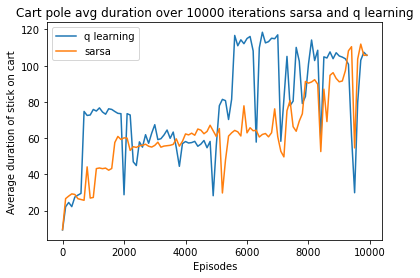

In [52]:
plt.plot(test_rewards_cart_q_learning.keys(), test_rewards_cart_q_learning.values() , label = 'q learning')
plt.plot(test_rewards_cart_sarsa.keys(), test_rewards_cart_sarsa.values(), label='sarsa')
plt.xlabel('Episodes')
plt.ylabel('Average duration of stick on cart')
plt.title('Cart pole avg duration over 10000 iterations sarsa and q learning')
plt.legend()
plt.show()